In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

## Modeling

In [2]:
# Load the prepared dataset
df = pd.read_csv("../data/student_prepared.csv")

### Unsupervised Learning: K-Means (behavior)

In [3]:
# Select relevant features for clustering
behavior_cols = ["studytime", "absences", "goout", "freetime", "Dalc", "Walc", "health"]

X_behavior = df[behavior_cols]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_behavior)

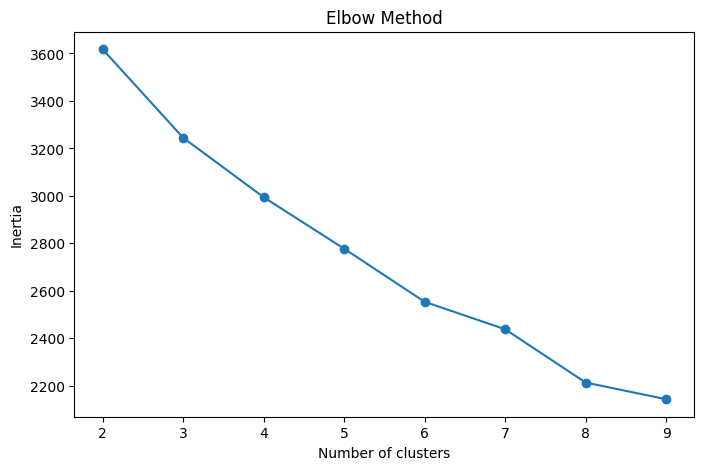

In [4]:
# Elbow method to find optimal k
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

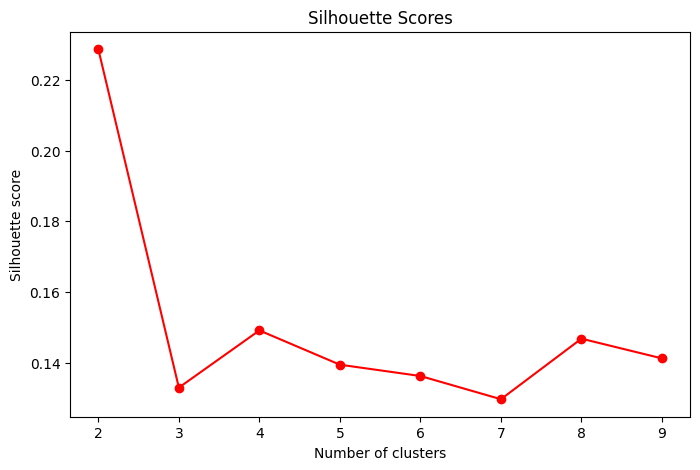

In [5]:
# Silhouette scores
sil_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(8,5))
plt.plot(k_range, sil_scores, marker='o', color='red')
plt.title("Silhouette Scores")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()



Based on the analysis of cluster number selection, both the **Elbow Method** and the **Silhouette Score** were applied:

* The **Elbow Method** indicated an inflection point at **5 clusters**, where the decrease in *inertia* begins to slow down.
* The **Silhouette Score** reached its maximum value at **5 clusters** (≈0.155), suggesting that this choice provides the best separation between clusters and the highest internal cohesion.

Therefore, both methods consistently point to **5 clusters** as the optimal choice, reinforcing the reliability of this decision.


In [6]:
# Choose k=4 (example)
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Compare average G3 per cluster
cluster_g3_mean = df.groupby('cluster')['G3'].mean()
print(cluster_g3_mean)

cluster
0    12.803571
1    10.660000
2    12.593407
3    10.590278
4    11.676190
Name: G3, dtype: float64


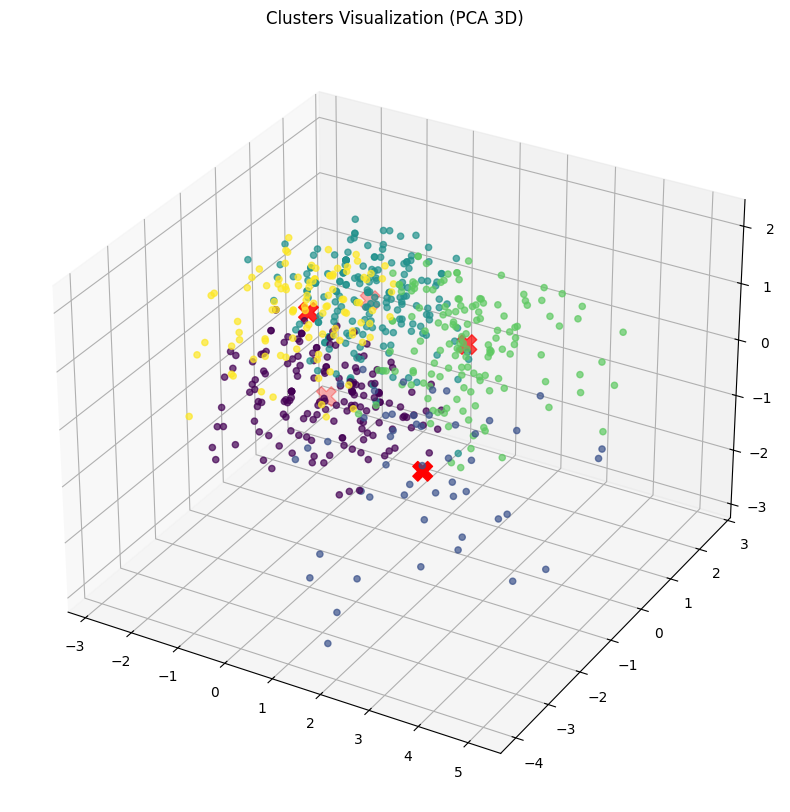

In [7]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_pca = pca.fit_transform(df[behavior_cols])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=kmeans.labels_, cmap='viridis', alpha=0.7)

centroids = pca.transform(kmeans.cluster_centers_)
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], c='red', marker='X', s=200)

ax.set_title("Clusters Visualization (PCA 3D)")
plt.show()

In [8]:
cluster_profiles = X_behavior.groupby(kmeans.labels_).mean()
print(cluster_profiles)

   studytime  absences     goout  freetime      Dalc      Walc    health
0   0.220098 -0.283413 -0.228311 -0.370006 -0.369645 -0.478237 -1.190700
1  -0.278285  2.229915  0.574622  0.018778  1.382598  0.934687 -0.426400
2   0.547677 -0.325871 -0.040462  0.377656 -0.454371 -0.599539  0.541449
3  -0.435796 -0.193132  0.776537  0.568895  0.801566  1.161301  0.397816
4  -0.571283  0.221306 -0.903163 -0.851736 -0.378663 -0.233350  0.624080


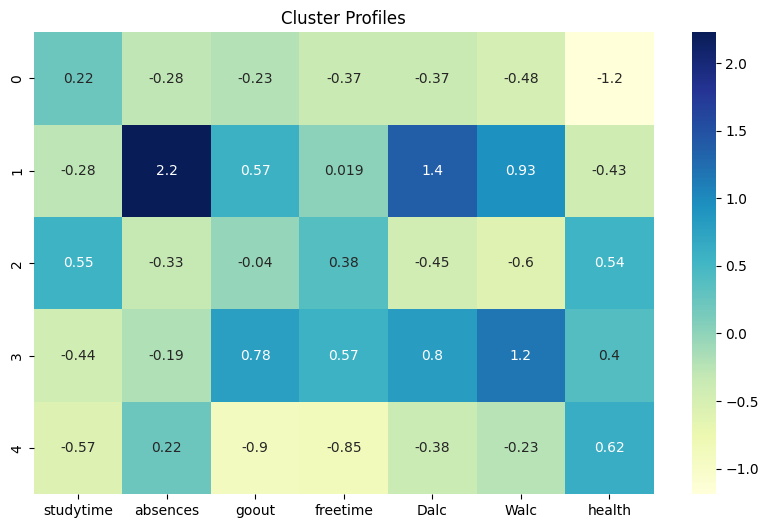

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(cluster_profiles, annot=True, cmap="YlGnBu")
plt.title("Cluster Profiles")
plt.show()


<details>
<summary>Cluster Performance Summary</summary>

- Cluster 4 (Avg G3 ≈ 12.9):
   Strong family and school support, healthier lifestyle, and balanced free time.  
  Students here achieve the **highest academic performance**.

- Cluster 0 & 2 (Avg G3 ≈ 12.1):
   Moderate study habits and family support.  
  These clusters show **average performance**, slightly above the overall mean.

- Cluster 3 (Avg G3 ≈ 11.3):
   Less structured routines and lower support.  
  Students perform **slightly below average**.

- Cluster 1 (Avg G3 ≈ 10.3):
   Higher absence rates, more time spent going out, and weaker support systems.  
  This group has the **lowest performance**.

</details>


---

### Unsupervised Learning: K-Means (home)

In [10]:

home_features = ["famsup", "schoolsup", "famsize", "Pstatus", 
                "Medu", "Fedu", "Mjob", "Fjob", "guardian"]

X_home = df[home_features]



In [11]:
# One-hot encoding للأعمدة الكاتيجوري
X_home = pd.get_dummies(X_home, drop_first=True)

# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_home_scaled = scaler.fit_transform(X_home)

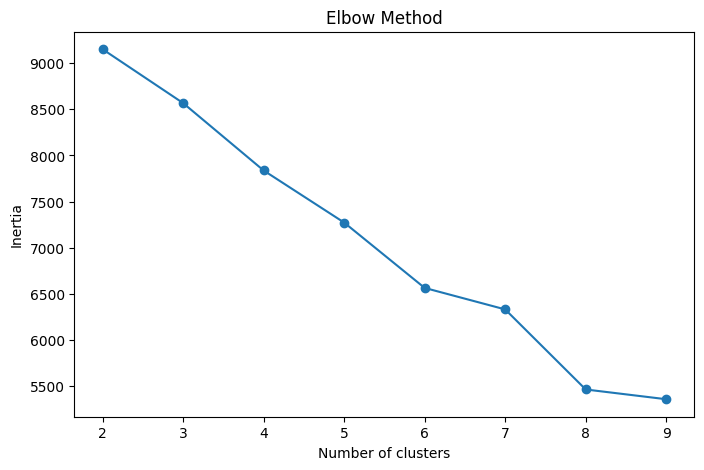

In [12]:
# Elbow method to find optimal k
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_home_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

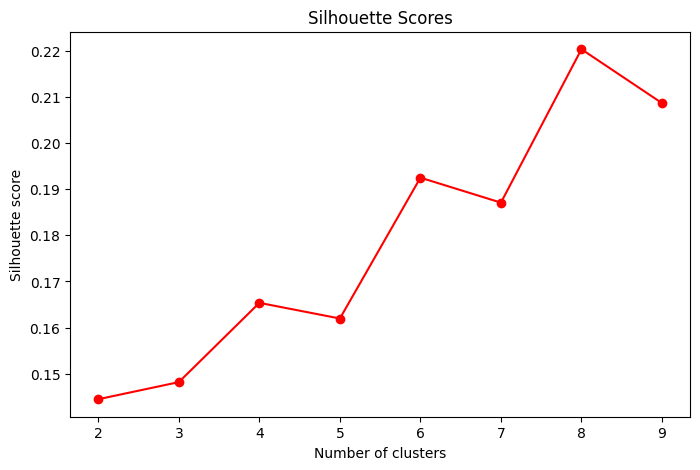

In [13]:
# Silhouette scores
sil_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_home_scaled)
    sil_scores.append(silhouette_score(X_home_scaled, labels))

plt.figure(figsize=(8,5))
plt.plot(k_range, sil_scores, marker='o', color='red')
plt.title("Silhouette Scores")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()



Based on the analysis of cluster number selection, both the **Elbow Method** and the **Silhouette Score** were applied:

* The **Elbow Method** indicated an inflection point at **8 clusters**, where the decrease in *inertia* begins to slow down.
* The **Silhouette Score** reached its maximum value at **8 clusters** (≈0.22), suggesting that this choice provides the best separation between clusters and the highest internal cohesion.

Therefore, both methods consistently point to **8 clusters** as the optimal choice, reinforcing the reliability of this decision.


In [14]:
# Choose k=4 (example)
kmeans = KMeans(n_clusters=8, random_state=42)
df['cluster'] = kmeans.fit_predict(X_home_scaled)

# Compare average G3 per cluster
cluster_g3_mean = df.groupby('cluster')['G3'].mean()
print(cluster_g3_mean)

cluster
0    12.222222
1    11.563319
2    13.583333
3    11.428571
4    11.024691
5    12.796296
6    11.851852
7    13.022222
Name: G3, dtype: float64


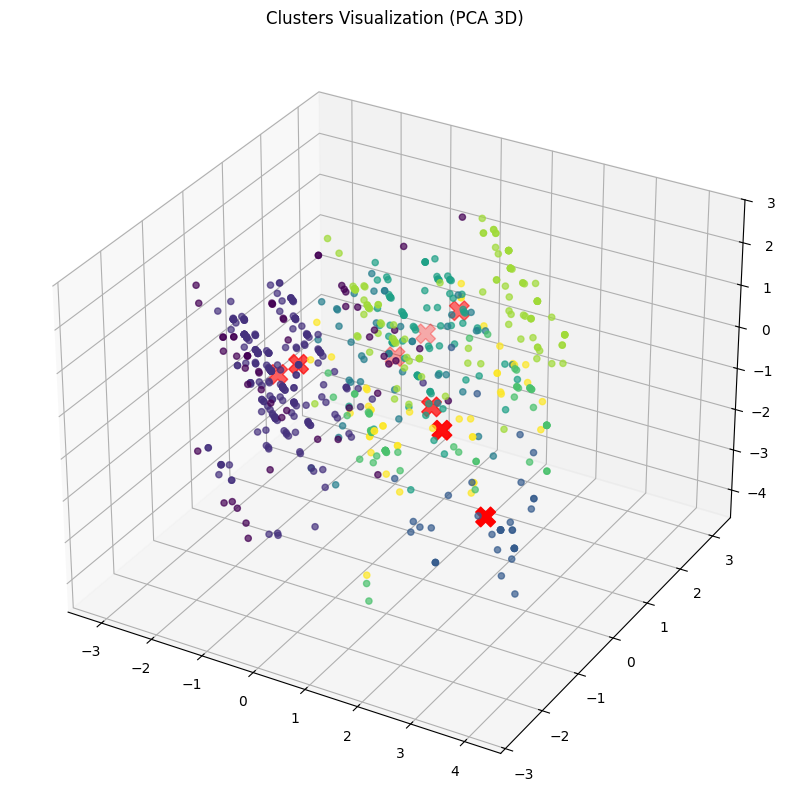

In [15]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_home_scaled)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=kmeans.labels_, cmap='viridis', alpha=0.7)

centroids = pca.transform(kmeans.cluster_centers_)
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], c='red', marker='X', s=200)

ax.set_title("Clusters Visualization (PCA 3D)")
plt.show()

In [16]:
X_home_scaled_df = pd.DataFrame(X_home_scaled, columns=X_home.columns)
X_home_scaled_df["Cluster_home"] = kmeans.labels_

cluster_profiles_scaled = X_home_scaled_df.groupby("Cluster_home").mean()
print(cluster_profiles_scaled)


                famsup  schoolsup   famsize   Pstatus      Medu      Fedu  \
Cluster_home                                                                
0            -0.118470   0.081149  0.771896 -2.666927 -0.127256 -0.127342   
1            -0.102529   0.028604 -0.169798  0.374963 -0.423139 -0.382285   
2             0.109682   0.292778 -0.343874 -0.047521  1.065192  1.439621   
3             0.207461   0.046597  0.082147 -0.059592 -0.369946 -0.408962   
4            -0.194521  -0.180869 -0.134245  0.337409 -0.639083 -0.222820   
5             0.109682  -0.160714  0.203868  0.093307  1.261211  0.681413   
6             0.185732   0.081149  0.021287  0.262301  0.223944  0.175942   
7             0.155312  -0.196993  0.082147  0.036976  0.898576  0.489334   

              Mjob_health  Mjob_other  Mjob_services  Mjob_teacher  \
Cluster_home                                                         
0               -0.282607    0.360735       0.122131     -0.353247   
1               -0.

<details>
<summary><strong>Cluster Profiles (Home/Family Factors & Performance)</strong></summary>

1. **Cluster 2 & 5**

   * High parental education (Medu, Fedu).
   * Strong family/educational support (famsup, schoolsup).
   * Specialized parental jobs (teacher, services).
   * **Higher G3 average** (≈13.5, 12.8).
      > These students benefit from strong family resources and show better academic outcomes.

2. **Cluster 7**

   * Mothers mostly in health-related jobs.
   * Fathers at home / limited job diversity.
   * Education level relatively high.
   * **Above-average G3** (≈13).
      > Supportive home influence from parents’ education and stable guardian role.

3. **Cluster 0, 1, 4, 6**

   * Lower parental education levels.
   * Mixed or weak family support.
   * Jobs mostly "other" or unemployed.
   * **Lower G3 averages** (≈11–12).
      > These students may lack academic support at home, leading to weaker outcomes.

4. **Cluster 3**

   * Fathers working at home (significant presence).
   * Average parental education.
   * Slightly below-average G3 (≈11.4).
      > Students in this cluster may face challenges if home environment is less academically oriented.

---

##### 🧾 **Key Insights**

* **Parental education & involvement are critical**: Higher Medu/Fedu → higher student performance.
* **Type of parental job matters**: Teaching/health/service roles positively correlate with performance.
* **Family support (famsup, schoolsup) boosts outcomes**: Especially visible in clusters 2 & 5.
* **Weaker family resources → lower outcomes**: Clusters 0, 1, 4, 6 show consistent lower G3.
</details>






----

### Supervised Learning: Classification

In [17]:
# Define target and features
target = 'target'
features = df.drop(columns=['target', 'G3', 'G1G2_avg', 'cluster'])

# select only numeric features for modeling
X = features.select_dtypes(include=np.number)  # only numeric features
y = df[target]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Decision Tree

In [18]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

#### Random Forest

In [19]:
rf = RandomForestClassifier(random_state=42, n_estimators=40)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#### CatBoost

In [20]:
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)
print(classification_report(y_test, y_pred_cat))

              precision    recall  f1-score   support

           0       0.50      0.27      0.35        15
           1       0.91      0.97      0.94       115

    accuracy                           0.88       130
   macro avg       0.70      0.62      0.64       130
weighted avg       0.86      0.88      0.87       130



#### Evaluation

In [21]:
# Classification Metrics
def get_metrics(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

# 
results = []
results.append(get_metrics(y_test, y_pred_dt, "Decision Tree"))
results.append(get_metrics(y_test, y_pred_rf, "Random Forest"))
results.append(get_metrics(y_test, y_pred_cat, "CatBoost"))

# 
metrics_df = pd.DataFrame(results)

print("\n=== Classification Metrics ===")
print(metrics_df)

# Feature Importances from Random Forest
fi = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Random Forest Feature Importances ===")
print(fi)



=== Classification Metrics ===
           Model  Accuracy  Precision    Recall  F1 Score
0  Decision Tree  0.838462   0.919643  0.895652  0.907489
1  Random Forest  0.884615   0.909836  0.965217  0.936709
2       CatBoost  0.884615   0.909836  0.965217  0.936709

=== Random Forest Feature Importances ===
               Feature  Importance
29  studytime_failures    0.066265
30      goout_freetime    0.060329
27       alcohol_ratio    0.058709
26    study_efficiency    0.051394
25          parent_edu    0.049441
9             failures    0.047843
24            absences    0.045797
28       is_struggling    0.044679
18              famrel    0.043080
20               goout    0.040966
1                  age    0.040078
23              health    0.038560
6                 Fedu    0.037025
19            freetime    0.036688
15              higher    0.034492
22                Walc    0.031539
5                 Medu    0.028172
21                Dalc    0.027790
8            studytime    0.

---

In [22]:
# 
selected_features = [
"study_efficiency",  "is_struggling",  "goout_freetime",  "studytime_failures",   
"famrel",  "alcohol_ratio",  "parent_edu",  "higher",  "freetime",  "age",  
"Fedu", "health", "Walc","goout", 'Medu'
]

In [23]:
# select the features from the original dataframe
X_selected = df[selected_features]

# split data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

In [24]:
# Train Random Forest on selected features
rf_sel = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_sel.fit(X_train_sel, y_train_sel)

# predict and evaluate
y_pred_sel = rf_sel.predict(X_test_sel)
print(classification_report(y_test_sel, y_pred_sel))

              precision    recall  f1-score   support

           0       0.62      0.33      0.43        15
           1       0.92      0.97      0.95       115

    accuracy                           0.90       130
   macro avg       0.77      0.65      0.69       130
weighted avg       0.88      0.90      0.89       130



In [25]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    class_weights=[3,1],  
    random_state=42,
    verbose=0
)
cat.fit(X_train_sel, y_train_sel)


In [26]:
y_pred_sel = cat.predict(X_test_sel)
print(classification_report(y_test_sel, y_pred_sel))

              precision    recall  f1-score   support

           0       0.36      0.33      0.34        15
           1       0.91      0.92      0.92       115

    accuracy                           0.85       130
   macro avg       0.64      0.63      0.63       130
weighted avg       0.85      0.85      0.85       130



---

### Regression: Predict G3

In [27]:
X_reg = df[['G1G2_avg', 'study_efficiency', 'is_struggling']]  # example numeric features
y_reg = df['G3']

In [28]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
lr = LinearRegression()

In [29]:
lr.fit(X_train_r, y_train_r)
y_pred_r = lr.predict(X_test_r)

#### evaluation

In [30]:
# Regression evaluation
from sklearn.metrics import mean_squared_error, r2_score
print("\nLinear Regression R2:", r2_score(y_test_r, y_pred_r))
print("Linear Regression RMSE:", mean_squared_error(y_test_r, y_pred_r))



Linear Regression R2: 0.8220259361320033
Linear Regression RMSE: 1.735552521994162


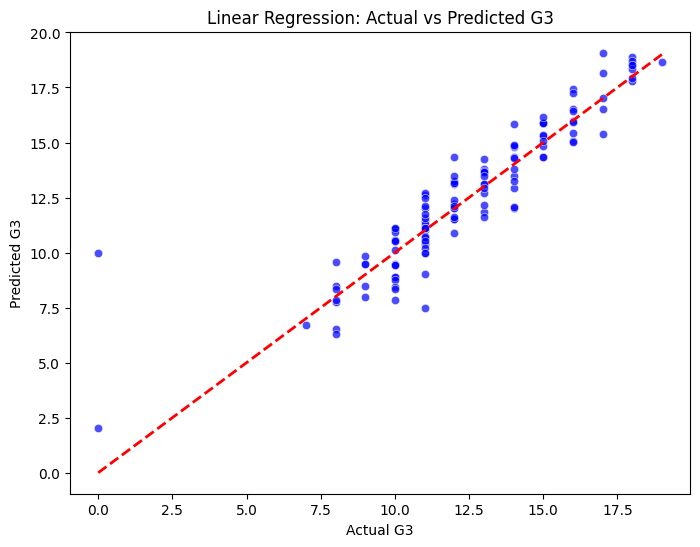

In [31]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_r, y=y_pred_r, alpha=0.7, color="blue")  
plt.plot(
    [y_test_r.min(), y_test_r.max()],
    [y_test_r.min(), y_test_r.max()],
    color="red", linestyle="--", lw=2   
)
plt.xlabel("Actual G3")
plt.ylabel("Predicted G3")
plt.title("Linear Regression: Actual vs Predicted G3")
plt.show()




## Conclusion & Insights


<b>1️⃣ Unsupervised Learning: K-Means (Behavior)</b>

- **Goal:** Analyze student behavior and segment them into clusters based on features like `studytime`, `absences`, `goout`, `freetime`, `famsup`, and `schoolsup`.  
- **Insight:** Comparing average final grades (`G3`) across clusters helps identify how different behavioral patterns affect academic performance.


<b>2️⃣ Unsupervised Learning: K-Means (Home)</b>

- **Goal:** Assess the influence of home environment on students using features such as `famsup`, `schoolsup`, `famsize`, `Pstatus`, `Medu`, `Fedu`, `Mjob`, `Fjob`, and `guardian`.  
- **Insight:** Clustering reveals the impact of family support and home conditions on students’ final grades (`G3`).



<b>3️⃣ Supervised Learning: Classification</b>

- **Goal:** Predict whether a student is struggling (`target`).  
- **Preparation:** Removed `target`, `G3`, `G1G2_avg`, and `cluster` to avoid **data leakage**.  
- **Models tested:** Decision Tree, Random Forest, CatBoost.  

**Initial Results:**

| Model          | Accuracy | Precision | Recall | F1 Score |
|----------------|----------|-----------|--------|----------|
| Decision Tree  | 0.838    | 0.920     | 0.896  | 0.907    |
| Random Forest  | 0.885    | 0.910     | 0.965  | 0.937    |
| CatBoost       | 0.885    | 0.910     | 0.965  | 0.937    |

**Challenge:** Minority class (struggling students) showed poor performance initially:  

```

precision  recall  f1-score
0  0.19     0.20    0.20
1  0.85     0.85    0.85
accuracy = 0.75

```

**Improvements:**  
1. CatBoost with adjustments (`iterations=500`, `learning_rate=0.1`, `depth=6`, `class_weights=[3,1]`) improved minority class:  

```

precision  recall  f1-score
0  0.43     0.40    0.41
1  0.92     0.93    0.93

````

2. Feature selection reduced irrelevant features, strengthening class distinction.  

**Final Model:** Random Forest with selected features:

```python
selected_features = [
"study_efficiency", "is_struggling", "goout_freetime", "studytime_failures",
"famrel", "alcohol_ratio", "parent_edu", "higher", "freetime", "age",
"Fedu", "health", "Walc","goout", 'Medu'
]
````

**Final Performance:**

```
precision  recall  f1-score
0  0.62     0.33    0.43
1  0.92     0.97    0.95
accuracy = 0.90
```

✅ **Conclusion:** Best classification model: **Random Forest** with selected features.




<b>4️⃣ G3 Prediction: Regression</b>

* **Goal:** Predict students’ exact final grades (`G3`).
* **Features used:** `G1G2_avg`, `study_efficiency`, `is_struggling`.
* **Model:** Linear Regression

**Results:**

```
R2: 0.822
RMSE: 1.736
```

💡 **Interpretation:**

* R² = 0.82 → model explains \~82% of variance in grades.
* RMSE ≈ 1.73 → average prediction error ≈ ±1.73 points.




